In [19]:
# Importing the necessary libraries
import numpy as np
from numpy import pi
from scipy.linalg import expm, sinm, cosm, sqrtm
import matplotlib.pyplot as plt

# Importing standard Qiskit libraries
from qiskit import *
from qiskit import Aer
from qiskit.circuit.library.standard_gates import XGate, MCXGate
from qiskit.extensions import UnitaryGate
from qiskit.quantum_info import Statevector
from qiskit.tools.jupyter import *
from qiskit.visualization import *

In [20]:
X_gate = np.array([[0, 1], [1, 0]], dtype = 'complex_')
Y_gate = np.array([[0, -1j], [1j, 0]], dtype = 'complex_')
Z_gate = np.array([[1, 0], [0, -1]], dtype = 'complex_')

H_gate = np.array([[1, 1], [1, -1]], dtype = 'complex_') / np.sqrt(2)

def R_x(theta):
    return np.array([[np.cos(theta/2), -1j*np.sin(theta/2)], [-1j*np.sin(theta/2), np.cos(theta/2)]], dtype = 'complex_')

def R_y(theta):
    return np.array([[np.cos(theta/2), -1j*np.sin(theta/2)], [np.sin(theta/2), np.cos(theta/2)]], dtype = 'complex_')

def R_z(theta):
    return np.array([[np.exp(-1j*theta/2), 0], [0, np.exp(1j*theta/2)]], dtype = 'complex_')

# QEVT

In [21]:
def QEVT(phi_vec, U):
    # create U gate
    U_gate = UnitaryGate(U, label="U")

    # create circuit
    nqubits = int(np.log2(U.shape[0]))
    q = QuantumRegister(nqubits, 'q')
    circuit = QuantumCircuit(q)

    circuit.rz(-2*phi_vec[0], q[0])

    for k in range(1, len(phi_vec)): 
        circuit.append(U_gate, q)  
        circuit.rz(-2*phi_vec[k], q[0])   

    #circuit.measure_all()
    return circuit

## Example: The Eigenvalue Threshold Problem

### Hamiltonian
Example: $H = \frac{1}{10} \cdot Z_1 \otimes Y_2 \otimes Z_3 + \frac25 \cdot X_1 \otimes Y_2 \otimes Y_3 - \frac15 \cdot Y_1 \otimes Y_2 \otimes Y_3 + \frac{1}{20} \cdot I_1 \otimes Z_2 \otimes X_3 + \frac{9}{20} \cdot I_1 \otimes I_2 \otimes I_3$

In [22]:
H = 0.1 * np.kron(Z_gate, np.kron(Y_gate, Y_gate)) + 0.4 * np.kron(X_gate, np.kron(Y_gate, Y_gate)) - 0.2 * np.kron(Y_gate, np.kron(Y_gate, Y_gate)) + 0.05 * np.kron(np.eye(2), np.kron(Z_gate, X_gate)) + 0.45 * np.kron(np.eye(2), np.kron(np.eye(2), np.eye(2)))

# norm of Hamiltonian mus be smaller than 1
H = H / (1.25 * np.linalg.norm(H))
np.linalg.norm(H)

0.8

### Block encoding
$$
U =
\begin{bmatrix}
\mathcal{H} & \cdot \\
\cdot & \cdot
\end{bmatrix}
=
\begin{bmatrix}
\mathcal{H} & \sqrt{I - \mathcal{H}^2} \\
\sqrt{I - \mathcal{H}^2} & -\mathcal{H}
\end{bmatrix}
=
Z \otimes \mathcal{H} + \mathcal{H} \otimes \sqrt{\mathcal{I} - \mathcal{H}^2}
$$

In [23]:
U = np.kron(Z_gate, H) + np.kron(X_gate, sqrtm(np.eye(H.shape[0]) - H @ H))

Check if U is unitary
$$
UU^{\dagger} = U^{\dagger}U =  I
$$
and if the the spectral norm is 1.

In [24]:
#check whether unitary
print(np.allclose(U @ U.conj().T, np.identity(U.shape[0])))
print(np.linalg.norm(U,2))

True
1.0000000000000007


### Calculate the phase angles

[pyqsp.poly.PolyEfilter] degree=30, delta=0.3
[PolyTaylorSeries] max [0.94955034] is at [2.19000128e-08]: normalizing
[PolyTaylorSeries] average error = 0.009629178075583878 in the domain [-1, 1] using degree 30


c:\Python311\Lib\site-packages\scipy\interpolate\_polyint.py:502: UserWarning: 31 degrees provided, degrees higher than about thirty cause problems with numerical instability with 'KroghInterpolator'
  P = KroghInterpolator(xs, f(xs))


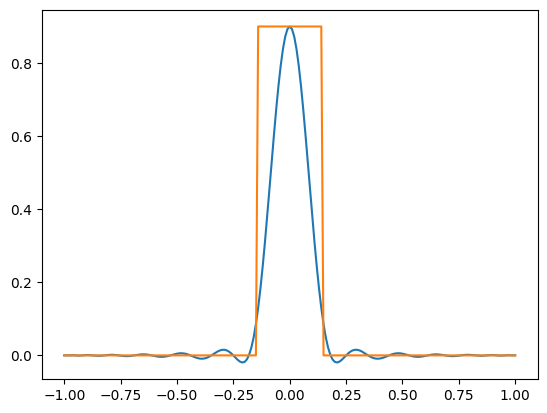

In [25]:
import pyqsp
from pyqsp.angle_sequence import QuantumSignalProcessingPhases

pg = pyqsp.poly.PolyEigenstateFiltering()
pcoeffs, scale = pg.generate(30, 0.3, ensure_bounded=True, return_scale=True)
ang_seq = QuantumSignalProcessingPhases(pcoeffs, signal_operator="Wz")

poly_filt = np.polynomial.Polynomial(pcoeffs)
poly_filt.degree()

a_list = np.linspace(-1, 1, 201)
plt.plot(a_list, poly_filt(a_list), label="polynomial")


def target_filt(x, delta, scale=1):
    """
    Target function for eigenvalue filtering.
    """
    return scale * (np.sign(x + 0.5*delta) - np.sign(x - 0.5*delta)) / 2

plt.plot(a_list, target_filt(a_list, 0.3, scale=0.9), label="target function")

In [26]:
def phase_diff(d):
    return np.array([np.pi/4] + (d-1)*[np.pi/2] + [np.pi/4])

d = len(ang_seq) - 1
ang_seq_QEVT = ang_seq - phase_diff(d)

In [27]:
print(ang_seq_QEVT)

[-0.68259887 -1.67889166 -1.34910948 -2.17834428 -1.34729989 -1.82481139
 -0.91739341 -1.07803879 -2.37666509 -2.30737176 -2.2056353  -0.99851073
 -1.6701889  -1.58963126 -0.95223975 -0.81062469 -4.0938324  -1.58963126
 -1.6701889  -0.99851073 -2.2056353   0.83422089 -2.37666509 -1.07803879
 -0.91739341 -1.82481139 -1.34729989 -2.17834428 -1.34910948 -1.67889166
  0.88819746]


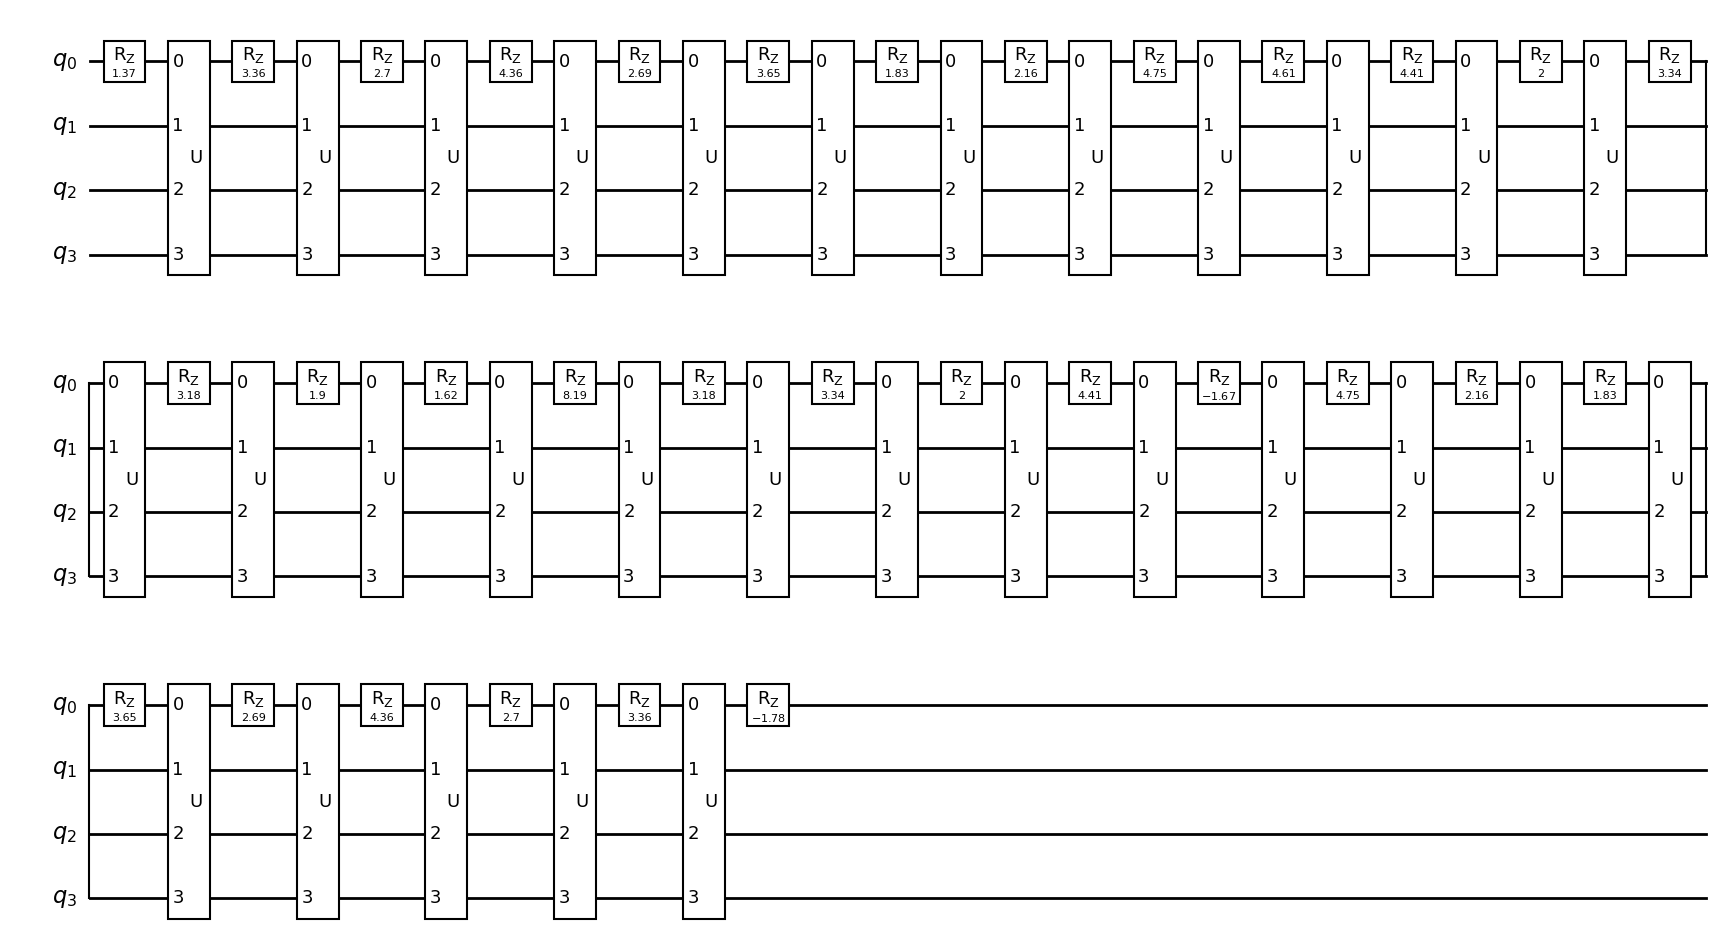

In [28]:
qc = QEVT(ang_seq_QEVT, U)
qc.draw('mpl', style="bw")

In [29]:
def get_matrix(circ):
    """
    Takes a qiskit circuit and returns the corresponding matrix
    """
    backend = Aer.get_backend('unitary_simulator')
    job = execute(circ, backend)
    result = job.result()
    matrix = np.array(result.get_unitary(circ, decimals=15))
    return matrix

Poly_H = get_matrix(qc)[0:8, 0:8]

λ: [ 0.20581607-0.j  0.20581607-0.j  0.13066134-0.j  0.13066134-0.j
 -0.13028638+0.j -0.13028638+0.j -0.2054411 +0.j -0.2054411 +0.j]


C:\Users\thilo\AppData\Roaming\Python\Python311\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


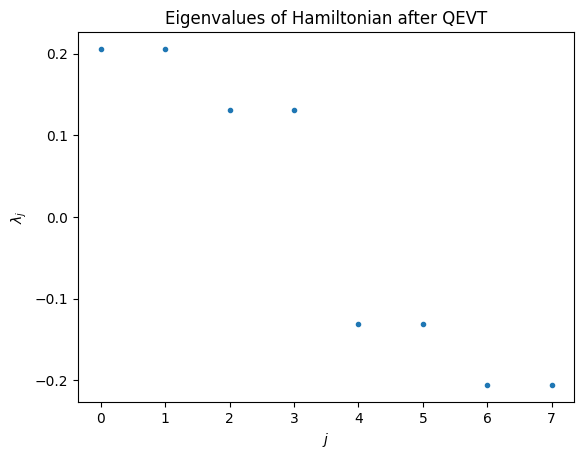

In [30]:
# calculate eigenvalues
λ, ψ = np.linalg.eigh(Poly_H)

# apply global phase
λ = λ*((-1j)**(len(ang_seq)-1))

print("λ:", λ)
plt.plot(λ, ".")
plt.xlabel(r"$j$")
plt.ylabel(r"$\lambda_j$")
plt.title("Eigenvalues of Hamiltonian after QEVT")
plt.show()

## Example: Hamiltonian Simulation

### Calculate phase angles for Hamiltonian simulation

#### Sine

15.537708063830353
R=7
[PolySineTX] rescaling by 0.5.


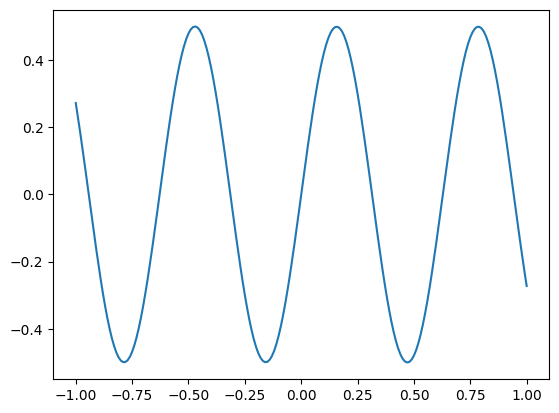

In [31]:
pg = pyqsp.poly.PolySineTX()
sin_pcoeffs, scale = pg.generate(10, 0.1, ensure_bounded=True, return_scale=True)
poly_filt = np.polynomial.Polynomial(sin_pcoeffs)
poly_filt.degree()

ang_seq_sin_QSP = QuantumSignalProcessingPhases(sin_pcoeffs, signal_operator="Wz")
d = len(ang_seq_sin_QSP) - 1
ang_seq_sin_QEVT = ang_seq_sin_QSP - phase_diff(d)

a_list = np.linspace(-1, 1, 201)
plt.plot(a_list, poly_filt(a_list), label="polynomial")

#### Cosine

15.537708063830353
R=7
[PolyCosineTX] rescaling by 0.5.


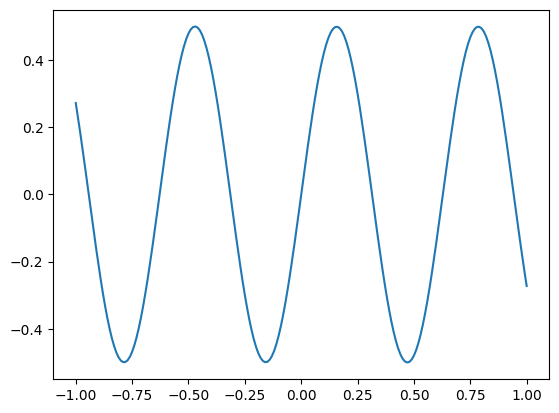

In [32]:
pg = pyqsp.poly.PolyCosineTX()
cos_pcoeffs, scale = pg.generate(10, 0.1, ensure_bounded=True, return_scale=True)
poly_filt = np.polynomial.Polynomial(sin_pcoeffs)
poly_filt.degree()

ang_seq_cos_QSP = QuantumSignalProcessingPhases(cos_pcoeffs, signal_operator="Wz")
d = len(ang_seq_cos_QSP) - 1
ang_seq_cos_QEVT = ang_seq_cos_QSP - phase_diff(d)

a_list = np.linspace(-1, 1, 201)
plt.plot(a_list, poly_filt(a_list), label="polynomial")

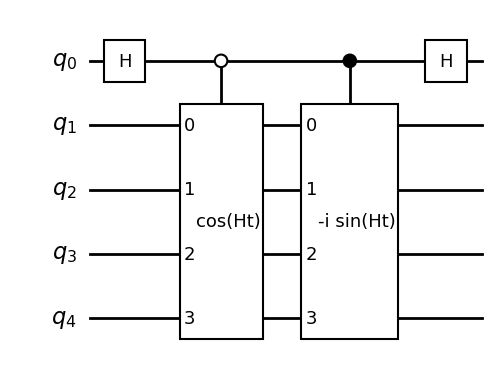

In [33]:
# create QEVT sine gate
qc_sin = QEVT(ang_seq_sin_QEVT, U)
# add phase gate
qc_sin.p(theta=1, qubit=0)
QEVT_sin_gate = qc_sin.to_gate(label="-i sin(Ht)").control(1, ctrl_state='1')

# create QEVT cosine gate
qc_cos = QEVT(ang_seq_cos_QEVT, U)
QEVT_cos_gate = qc_sin.to_gate(label="cos(Ht)").control(1, ctrl_state='0')

# create circuit for Hamiltonian simulation
nqubits = int(np.log2(U.shape[0])) + 1
H_sim_circ = QuantumCircuit(nqubits)
H_sim_circ.h(0)
H_sim_circ.append(QEVT_cos_gate, [0,1,2,3,4])
H_sim_circ.append(QEVT_sin_gate, [0,1,2,3,4])
H_sim_circ.h(0)
H_sim_circ.draw('mpl', style="bw")

In [34]:
matrix = get_matrix(H_sim_circ)[0:8, 0:8]
expected = expm(-10j*H)
print(np.linalg.norm(matrix - expected))

2.8809487270140326
